## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_files 
from keras.utils import np_utils
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import tensorflow_datasets as tfds

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
img_height = 299
img_width = 299

In [ ]:
!unzip "/content/4Classes.zip"

In [ ]:
data_dir = "/content/Classes/"
data_directory = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_directory.glob('*/*.jpg')))
print(image_count)

3381


In [ ]:
list_ds = tf.data.Dataset.list_files(str("/content/Classes/*/*"))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/Classes/Non-Streetlights/Image-2473-30.jpg'
b'/content/Classes/Enclosed Streetlights/Image-31-30.jpg'
b'/content/Classes/Non-Streetlights/Image-403-30.jpg'
b'/content/Classes/Enclosed Streetlights/Image-1613-30.jpg'
b'/content/Classes/Non-Streetlights/Image-1345-30.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_directory.glob('*') ]))
print(class_names)

['Colonial Streetlights' 'Enclosed Streetlights' 'Non-Streetlights'
 'Open Streetlights']


In [ ]:
train_size = int(0.7 * image_count)
val_size = int(0.15 * image_count)
test_size = int(0.15 * image_count)


list_ds= list_ds.shuffle(50)
train_dataset = list_ds.take(train_size)
test_dataset = list_ds.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(val_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

2366
508
507


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  2


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_set= configure_for_performance(train_ds)
valid_set = configure_for_performance(val_ds)
test_set = configure_for_performance(test_ds)

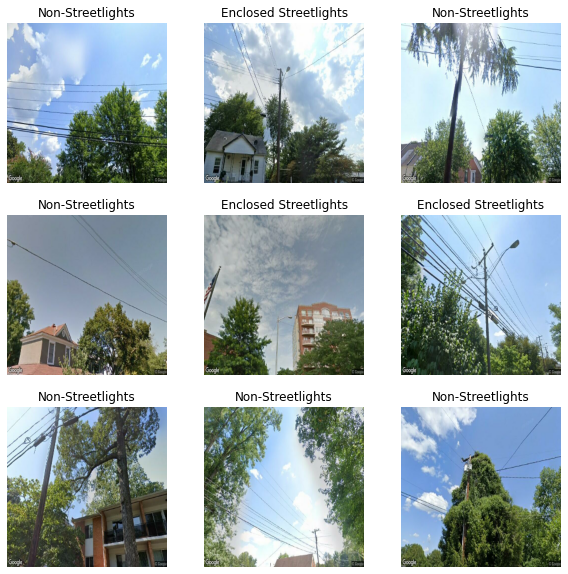

In [ ]:
image_batch, label_batch = next(iter(train_set))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
from tensorflow.keras import layers
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_ds = valid_set.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_set.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
def preprocess(image, label):
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

In [ ]:
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [ ]:
train_ds = train_ds.shuffle(500).repeat(10) 
train_ds = train_ds.map(data_augmentation)
train_ds = train_ds.map(preprocess)
valid_ds = validation_ds.map(preprocess)
test_ds = test_ds.map(preprocess)


In [ ]:
train_ds

<MapDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
valid_ds

<MapDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>

## Two Layer Model


In [ ]:
## State Variables 
n_classes=4
dataset_size=image_count

base_model2 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet")

base_model2.trainable = False

avg2 = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output2 = keras.layers.Dense(n_classes, activation="softmax")(avg2)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output2)

In [ ]:
for index, layer in enumerate(base_model2.layers):
    print(index, layer.name)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor ='val_accuracy',
                               patience = 10,
                               verbose = 1,
                               mode = 'max',
                               baseline = None,
                               restore_best_weights = True)

In [ ]:
#Run Base Model 

optimizer = keras.optimizers.Adam(learning_rate=0.005)

model2.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer, metrics=["accuracy"])

history = model2.fit(train_ds, 
                     epochs=10, validation_data=valid_ds, callbacks = [early_stopping])

Epoch 1/10
740/740 [==============================] - 163s 177ms/step - loss: 1.0872 - accuracy: 0.5116 - val_loss: 1.0291 - val_accuracy: 0.5551
Epoch 2/10
740/740 [==============================] - 128s 170ms/step - loss: 1.0347 - accuracy: 0.5253 - val_loss: 1.0201 - val_accuracy: 0.5492
Epoch 3/10
740/740 [==============================] - 128s 170ms/step - loss: 1.0254 - accuracy: 0.5292 - val_loss: 1.0542 - val_accuracy: 0.4646
Epoch 4/10
740/740 [==============================] - 129s 171ms/step - loss: 0.9885 - accuracy: 0.5532 - val_loss: 0.9887 - val_accuracy: 0.5669
Epoch 5/10
740/740 [==============================] - 128s 170ms/step - loss: 0.9873 - accuracy: 0.5512 - val_loss: 0.9993 - val_accuracy: 0.5531
Epoch 6/10
740/740 [==============================] - 128s 170ms/step - loss: 0.9796 - accuracy: 0.5545 - val_loss: 0.9698 - val_accuracy: 0.5709
Epoch 7/10
740/740 [==============================] - 129s 171ms/step - loss: 0.9602 - accuracy: 0.5624 - val_loss: 0.9498 -

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


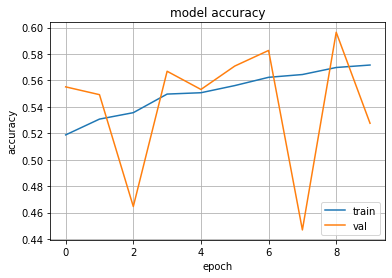

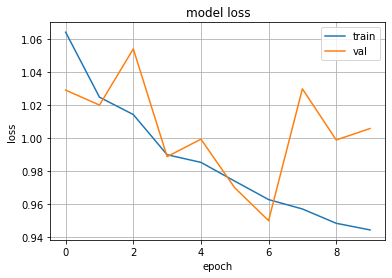

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid(True)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor ='val_accuracy',
                               patience = 10,
                               verbose = 1,
                               mode = 'max',
                               baseline = None,
                               restore_best_weights = True)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

base_model2.trainable = True

model2.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history3 = model2.fit(train_ds, 
                     validation_data=valid_ds,
                     epochs=10, callbacks = [early_stopping])

Epoch 1/10
740/740 [==============================] - 321s 407ms/step - loss: 11.0988 - accuracy: 0.7598 - val_loss: 2.0549 - val_accuracy: 0.8602
Epoch 2/10
740/740 [==============================] - 299s 401ms/step - loss: 0.1396 - accuracy: 0.9737 - val_loss: 0.5180 - val_accuracy: 0.9587
Epoch 3/10
740/740 [==============================] - 299s 401ms/step - loss: 0.0432 - accuracy: 0.9907 - val_loss: 0.7048 - val_accuracy: 0.9508
Epoch 4/10
740/740 [==============================] - 299s 401ms/step - loss: 0.0275 - accuracy: 0.9929 - val_loss: 0.7666 - val_accuracy: 0.9449
Epoch 5/10
740/740 [==============================] - 300s 402ms/step - loss: 0.0250 - accuracy: 0.9952 - val_loss: 1.0408 - val_accuracy: 0.9252
Epoch 6/10
740/740 [==============================] - 300s 402ms/step - loss: 0.0284 - accuracy: 0.9938 - val_loss: 0.7752 - val_accuracy: 0.9587
Epoch 7/10
740/740 [==============================] - 299s 401ms/step - loss: 0.0246 - accuracy: 0.9950 - val_loss: 1.0435 

## Evaluate with Test Set n=507

In [ ]:
print('Evaluating')
test_loss, test_acc = model2.evaluate(test_ds)
print('\nTest accuracy:', test_acc)

Evaluating
16/16 [==============================] - 3s 173ms/step - loss: 1.1922 - accuracy: 0.9290

Test accuracy: 0.9289940595626831


In [ ]:
#Save Model
model2.save('streetlight_model.h5')

## Load Images for Predictions

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive')
!pwd

/content/gdrive/MyDrive


In [ ]:
 from keras.models import load_model
 streetlight_model = load_model("/content/gdrive/MyDrive/streetlight_model.h5")

In [ ]:
## Saving Model to saved_model format
model = streetlight_model
model_version = '01'
model_name = 'streetlight_inception'
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: streetlight_inception/01/assets


In [ ]:
# Paths for Prediction Images
from tensorflow.keras.preprocessing import image

#img_path ='/content/gdrive/MyDrive/Streetlight_predict/Colonial/Copy of F2324TJ7000-zMIy2lPZN58QDf73d2Z2EQ-COLN-150-HPS-23.jpg'    # colonial
#img_path = '/content/gdrive/MyDrive/Streetlight_predict/Enclosed/Copy of Image-17-30.jpg' # Enclosed
img_path = '/content/gdrive/MyDrive/Streetlight_predict/Open/Image-OPEN-8-60.jpg' # open
#img_path = '/content/gdrive/MyDrive/Streetlight_predict/Non_streetlight/Copy of Image-2-30.jpg' # non-streetlight
img = image.load_img(img_path, target_size=(299, 299))

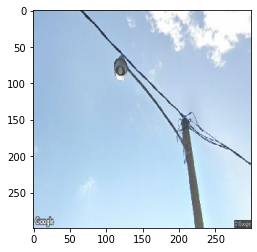

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

img_array = tf.keras.preprocessing.image.array_to_img(img)
img_batch = np.expand_dims(img_array, axis=0)
img_scaled = tf.keras.layers.experimental.preprocessing.Rescaling(1/255, 0.0, "rescaling")(img_batch)
image = tf.keras.applications.inception_resnet_v2.preprocess_input(img_scaled)
prediction = streetlight_model.predict(image)

In [ ]:
class_order = ['Boom - Colonial Streetlight' , 'Boom - Enclosed Streetlight', 'Boom - Non-Streetlight',
 'Boom - Open Streetlight']

In [ ]:
#class probabilites
prediction

array([[5.510617e-12, 7.477756e-04, 9.825814e-05, 9.991540e-01]],
      dtype=float32)

In [ ]:
predicted_class = np.argmax(prediction[0])
predicted_class

3

In [ ]:
class_name =class_order[np.argmax(prediction)]
class_name

'Boom - Open Streetlight'



## Set Up Train, Validatation and Test Set Generator - Dataframes

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator


def ShuffleDataframe(thedataframe):
    thedataframe = thedataframe.sample(n=len(thedataframe), random_state=42)
    thedataframe = thedataframe.reset_index()
    thedataframe.drop('index', axis='columns', inplace=True)
    return(thedataframe)


def TransformGeneratorClassNumberToLabels(theGenerator, theLabelsNumbers):
    labelnames = theGenerator.class_indices
    labelnames =  list(labelnames.keys())
    theLabelsString = [labelnames[i] for i in theLabelsNumbers]
    return(theLabelsString)


def GetGeneratorDataframe(theGenerator):
    training_filenames = theGenerator.filenames    
    theLabelsNumbers = theGenerator.classes
    
    thelabelsString =  TransformGeneratorClassNumberToLabels(theGenerator, 
                                                             theLabelsNumbers)

    
    
    
    thedataframe = pd.DataFrame({'File': training_filenames,
                                'Label': thelabelsString})

    thedataframe = ShuffleDataframe(thedataframe)
    return(thedataframe)   

def GetTrainValidTestGeneratorFromDir(thedirectory,
                                      input_shape= (299, 299, 3),
                                      validation_split=0.1,
                                      rescaling = 1./255):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2)   
    
    
    train_and_valid_generator = train_datagen.flow_from_directory(thedirectory,
                                                                  target_size=input_shape[0:2],
                                                                  batch_size=20,
                                                                  class_mode="categorical",
                                                                  subset = 'training',
                                                                  save_to_dir ='checkdir')
    
    test_generator = train_datagen.flow_from_directory(thedirectory,
                                                       target_size=input_shape[0:2],
                                                       batch_size=20,
                                                       class_mode="categorical",
                                                       subset = 'validation')
    
    thedataframe = GetGeneratorDataframe(train_and_valid_generator)
    

  
        
    training_generator = train_datagen.flow_from_dataframe(dataframe = thedataframe,
                                                           directory = thedirectory,
                                                           target_size=input_shape[0:2],
                                                           x_col="File",
                                                           y_col = "Label",
                                                           subset= "training",
                                                           class_mode="categorical")    


    validation_generator = train_datagen.flow_from_dataframe(dataframe = thedataframe,
                                                             directory = thedirectory,
                                                             target_size=input_shape[0:2],
                                                             x_col="File",
                                                             y_col = "Label",
                                                             subset= "validation",
                                                             class_mode="categorical")
    return training_generator, validation_generator, test_generator 



input_shape = (299, 299, 3)
myDir      = "/content/gdrive/MyDrive/Classes"

(training_generator, 
 validation_generator, 
 test_generator) = GetTrainValidTestGeneratorFromDir(myDir)

# next part is just to verify whhat you got

training_dataframe = GetGeneratorDataframe(training_generator)
valid_dataframe = GetGeneratorDataframe(validation_generator)
test_dataframe = GetGeneratorDataframe(test_generator)

Found 2705 images belonging to 4 classes.
Found 675 images belonging to 4 classes.
Found 2164 validated image filenames belonging to 4 classes.
Found 541 validated image filenames belonging to 4 classes.


In [ ]:
training_dataframe.head()

,File,Label
0,Non-Streetlights/Image-1917-30.jpg,Non-Streetlights
1,Non-Streetlights/Image-19-30.jpg,Non-Streetlights
2,Enclosed Streetlights/Image-2987-30.jpg,Enclosed Streetlights
3,Non-Streetlights/Image-551-30.jpg,Non-Streetlights
4,Enclosed Streetlights/Image-2150-30.jpg,Enclosed Streetlights


In [ ]:
training_dataframe['Label'].value_counts()

Non-Streetlights         1183
Enclosed Streetlights     667
Colonial Streetlights     260
Open Streetlights          54
Name: Label, dtype: int64

In [ ]:
valid_dataframe['Label'].value_counts()

Non-Streetlights         293
Enclosed Streetlights    161
Colonial Streetlights     69
Open Streetlights         18
Name: Label, dtype: int64

In [ ]:
test_dataframe['Label'].value_counts()

Non-Streetlights         369
Enclosed Streetlights    207
Colonial Streetlights     82
Open Streetlights         17
Name: Label, dtype: int64

In [ ]:
valid_dataframe

,File,Label
0,Enclosed Streetlights/Image-2276-30.jpg,Enclosed Streetlights
1,Non-Streetlights/Image-35-30.jpg,Non-Streetlights
2,Enclosed Streetlights/Image-2098-30.jpg,Enclosed Streetlights
3,Colonial Streetlights/G0025BA4500-4yq4CJlEo4zU...,Colonial Streetlights
4,Non-Streetlights/Image-2162-30.jpg,Non-Streetlights
...,...,...
536,Enclosed Streetlights/Image-809-30.jpg,Enclosed Streetlights
537,Non-Streetlights/Image-21-30.jpg,Non-Streetlights
538,Colonial Streetlights/Image-COLN-168-20.jpg,Colonial Streetlights
539,Non-Streetlights/Image-709-30.jpg,Non-Streetlights


In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator


def ShuffleDataframe(thedataframe):
    thedataframe = thedataframe.sample(n=len(thedataframe), random_state=42)
    thedataframe = thedataframe.reset_index()
    thedataframe.drop('index', axis='columns', inplace=True)
    return(thedataframe)


def TransformGeneratorClassNumberToLabels(theGenerator, theLabelsNumbers):
    labelnames = theGenerator.class_indices
    labelnames =  list(labelnames.keys())
    theLabelsString = [labelnames[i] for i in theLabelsNumbers]
    return(theLabelsString)


def GetGeneratorDataframe(theGenerator):
    training_filenames = theGenerator.filenames    
    theLabelsNumbers = theGenerator.classes
    
    thelabelsString =  TransformGeneratorClassNumberToLabels(theGenerator, 
                                                             theLabelsNumbers)

    
    
    
    thedataframe = pd.DataFrame({'File': training_filenames,
                                'Label': thelabelsString})

    thedataframe = ShuffleDataframe(thedataframe)
    return(thedataframe)   

def GetTrainValidTestGeneratorFromDir(thedirectory,
                                      input_shape= (299, 299, 3),
                                      validation_split=0.1,
                                      rescaling = 1./255):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2)   
    
    
    train_and_valid_generator = train_datagen.flow_from_directory(thedirectory,
                                                                  target_size=input_shape[0:2],
                                                                  batch_size=batch_size,
                                                                  class_mode="categorical",
                                                                  subset = 'training',
                                                                  save_to_dir ='checkdir')
    
    test_generator = train_datagen.flow_from_directory(thedirectory,
                                                       target_size=input_shape[0:2],
                                                       batch_size=batch_size,
                                                       class_mode="categorical",
                                                       subset = 'validation')
    
    thedataframe = GetGeneratorDataframe(train_and_valid_generator)
    

    class_mode = "categorical"
        
    training_generator = train_datagen.flow_from_dataframe(dataframe = thedataframe,
                                                           directory = thedirectory,
                                                           target_size=input_shape[0:2],
                                                           x_col="File",
                                                           y_col = "Label",
                                                           subset= "training",
                                                           class_mode=class_mode)    


    validation_generator = train_datagen.flow_from_dataframe(dataframe = thedataframe,
                                                             directory = thedirectory,
                                                             target_size=input_shape[0:2],
                                                             x_col="File",
                                                             y_col = "Label",
                                                             subset= "validation",
                                                             class_mode=class_mode)
    return training_generator, validation_generator, test_generator 



input_shape = (299, 299, 3)
myDir      = "/content/Classes"

(training_generator, 
 validation_generator, 
 test_generator) = GetTrainValidTestGeneratorFromDir(myDir)

# next part is just to verify whhat you got

training_dataframe = GetGeneratorDataframe(training_generator)
valid_dataframe = GetGeneratorDataframe(validation_generator)
test_dataframe = GetGeneratorDataframe(test_generator)

Found 2938 images belonging to 3 classes.
Found 733 images belonging to 3 classes.
Found 2351 validated image filenames belonging to 3 classes.
Found 587 validated image filenames belonging to 3 classes.


In [ ]:
base_model = keras.applications.InceptionResNetV2(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor ='val_accuracy',
                               patience = 10,
                               verbose = 1,
                               mode = 'max',
                               baseline = None,
                               restore_best_weights = True)

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=['accuracy'])
# additional metrics['acc', f1_m,precision_m, recall_m]

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = [early_stopping],
                    epochs=100)